In [1]:
import os
os.environ['PYTHONIOENCODING'] = 'utf8' # 시스템 기본 인코딩 변경
os.environ['LOKY_MAX_CPU_COUNT'] = '4' #
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# 📌Import Module & Load Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import scipy
import torch
import math

# preprocessing
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

# cv
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict

# model
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


# pipeline & ensemble
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

# parameter
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

In [3]:
df_train=pd.read_csv('C:/Users/Gyeom/.kaggle/input/playground-series-s3e24/train.csv')
df_test=pd.read_csv('C:/Users/Gyeom/.kaggle/input/playground-series-s3e24/test.csv')

---

# ⚙️Setting

In [4]:
ids_test = df_test['id']
df_train = df_train.drop(columns='id')
df_test = df_test.drop(columns='id')

In [5]:
print(df_train.shape)
print(df_test.shape)

(159256, 23)
(106171, 22)


In [6]:
# print(df_train.isna().sum().any())
# print(df_test.isna().sum().any())

In [7]:
df_train.columns.to_list()

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries',
 'smoking']

In [8]:
# df_train.describe()

In [9]:
seed = 42
n_splits = 10
str_kf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=seed)

In [10]:
# 주어진 데이터를 특성 행렬 (X)과 타겟 벡터 (y)로 분할
def generateXY(trainData):
    x = trainData.drop(columns='smoking')
    y = trainData.smoking
    return x,y

In [11]:
# def cv_feature(X, y, features, method_name):
#     # Drop unuseless features
#     for i,val in enumerate(X.columns):
#         if val not in features:
#             X = X.drop(columns=val)
            
#     # Initialize KFold object.
#     str_kf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=seed)

#     auc_scores = []

#     for train_index, valid_index in str_kf.split(X,y):
#         X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#         y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

#         model = CatBoostClassifier(random_state=seed, logging_level = 'Silent')
#         # Model to ensure that it's fresh for each fold.
#         model.fit(X_train, y_train)
    
#         # Predict on the validation data and calculate ROC AUC score.
#         val_predictions = model.predict_proba(X_valid)[:, 1]
#         roc_auc=roc_auc_score(y_valid, val_predictions)
#         auc_scores.append(roc_auc)

#     print(f'{method_name} has ROC AUC Score(Avg) = {np.mean(auc_scores):.7f}')

In [12]:
# n = len(df_test.columns)
# n_cols = 3
# n_rows = math.ceil(n / n_cols)

# fig , axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
# for col, ax in zip(df_test.columns, axs.ravel()):
#     if df_train[col].dtype == float:
#         ax.hist(df_train[col], bins=100, color='#529BEB')
#     else: #int
#         vc = df_train[col].value_counts()
#         ax.bar(vc.index, vc, color='#529BEB')
#     ax.set_xlabel(col)

# # 여분의 subplot 공간을 제거합니다.
# for ax in axs.flatten()[n:]:
#     fig.delaxes(ax)

# plt.tight_layout()
# plt.suptitle('Feature distributions', y=1.02, fontsize=20)
# plt.show()

In [13]:
# _, axs = plt.subplots(7, 3, figsize=(12, 12))
# for col, ax in zip(df_test.columns, axs.ravel()):
#     ax.hist(np.log1p(df_train[col]), bins=100, color='#B65FCF')
#     ax.set_xlabel(col)
# plt.tight_layout()
# plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
# plt.show()

In [14]:
# # train과 test 데이터셋 상관관계 분석
# # ROC-AUC 스코어가 0.5에 가까울수록 두 데이터셋이 비슷하다고 볼 수 있다.
# #https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation

# def adversarial_validation(dataset_1 = df_train, dataset_2 = df_test, label = 'Train-Test'):

#     adv_train = dataset_1.drop('smoking', axis = 1)
#     adv_test = dataset_2.copy()

#     adv_train['is_test'] = 0
#     adv_test['is_test'] = 1

#     adv = pd.concat([adv_train, adv_test], ignore_index = True)

#     adv_shuffled = adv.sample(frac = 1)

#     adv_X = adv_shuffled.drop('is_test', axis = 1)
#     adv_y = adv_shuffled.is_test

#     skf = StratifiedKFold(n_splits = n_splits, random_state = 42, shuffle = True)

#     val_scores = []
#     predictions = np.zeros(len(adv))

#     for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
    
#         adv_lr = XGBClassifier(random_state = 42)
#         adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])
        
#         val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
#         predictions[val_idx] = val_preds
#         val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
#         val_scores.append(val_score)
    
#     fpr, tpr, _ = roc_curve(adv['is_test'], predictions)
    
#     plt.figure(figsize = (10, 10), dpi = 300)
#     sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
#     sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
#     plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()

# adversarial_validation()

---

# 🚥Feature Engineering

In [15]:
# reference: https://www.kaggle.com/competitions/playground-series-s3e24/discussion/450314
# reference: https://www.kaggle.com/code/arunklenin/ps3e24-eda-feature-engineering-ensemble#1.-INTRODUCTION

def add_new_features(df):
    df_col = df.columns.to_list()
    if 'smoking' in df_col:
        smoking_ = df['smoking']
        df = df.drop(columns='smoking')

#     ############ BMI ############
#     df['BMI'] = df['weight(kg)'] / ((df['height(cm)']/100) ** 2)
#     # df = df.drop(columns=['weight(kg)','height(cm)'])

#     if 'BMI' in df.columns:
#         df['BMI_AST_interaction'] = df['BMI'] * df['AST']
#         df['BMI_ALT_interaction'] = df['BMI'] * df['ALT']
#         df['BMI_GTP_interaction'] = df['BMI'] * df['Gtp']

#     ############ 평균 혈압 ############
#     df['average_blood_pressure'] = (df['systolic'] + df['relaxation']) / 2
#     # df = df.drop(columns=['systolic','relaxation'])

#     ############ 콜레스테롤 비율 ############
#     df['cholesterol_ratio'] = np.where(df['HDL'] != 0, df['LDL'] / df['HDL'], 0)
#     # df = df.drop(columns=['HDL','LDL'])

#     ############ 평균 시력 ############
#     df['average_eyesight'] = (df['eyesight(left)'] + df['eyesight(right)']) / 2
#     # df = df.drop(columns=['eyesight(left)','eyesight(right)'])

#     ############ BMI 관련 피처 ############
#     df['BMI'] = df['weight(kg)'] / (df['height(cm)'] / 100) ** 2
#     df['BMI_category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 35, 40, np.inf], labels=[0, 1, 2, 3, 4, 5])
#     df['BMI_category'] = df['BMI_category'].astype('int')

#     ############ 허리 둘레 관련 피처 ############
#     df['waist_risk'] = pd.cut(df['waist(cm)'], bins=[0, 94, 102, np.inf], labels=[0, 1, 2])
#     df['waist_risk'] = df['waist_risk'].astype('int')

#     ############ 나이 관련 피처 ############
#     df['age_risk'] = np.where(df['age'] >= 45, 1, 0)

    ############ ★혈압 관련 피처 ############
    # 'systolic' 특성을 카테고리화
    # pd.cut 함수를 사용하면 결과값이 문자열로 반환
    df['BP_category'] = pd.cut(df['systolic'], bins=[0, 120, 130, 140, 180, np.inf], labels=[0, 1, 2, 3, 4])
    df['BP_category'] = df['BP_category'].astype('int')

#     ############ 콜레스테롤 관련 피처 ############
#     df['total_cholesterol_risk'] = pd.cut(df['Cholesterol'], bins=[0, 200, 240, np.inf], labels=[0, 1, 2])
#     df['total_cholesterol_risk'] = df['total_cholesterol_risk'].astype('int')
    
#     df['HDL_risk'] = pd.cut(df['HDL'], bins=[0, 40, 60, np.inf], labels=[0, 1, 2])
#     df['HDL_risk'] = df['HDL_risk'].astype('int')
    
#     df['LDL_risk'] = pd.cut(df['LDL'], bins=[0, 100, 130, 160, 190, np.inf], labels=[0, 1, 2, 3, 4])
#     df['LDL_risk'] = df['LDL_risk'].astype('int')

#     ############ 간 효소 관련 피처 ############
#     df['AST_ALT_ratio'] = df['AST'] / df['ALT']
#     df['AST_GTP_ratio'] = df['AST'] / df['Gtp']
#     df['ALT_GTP_ratio'] = df['ALT'] / df['Gtp']

#     ############ 펄스 압 ############
#     df['pulse_pressure'] = df['systolic'] - df['relaxation']

#     ############ 시력 차이 ############
#     df['eyesight_diff'] = df['eyesight(left)'] - df['eyesight(right)']

#     ############ 청력 차이 ############
#     df['hearing_diff'] = df['hearing(left)'] - df['hearing(right)']
    
#     ############ 혈당과 콜레스테롤의 상호작용 ############
#     df['glucose_cholesterol_interaction'] = df['fasting blood sugar'] * df['Cholesterol']

#     ############ 체중과 허리둘레의 상호작용 ############
#     df['weight_waist_interaction'] = df['weight(kg)'] * df['waist(cm)']

    # ############ 시력 차이2 ############
    # # 보통 시력 상한은 2, 근데 9 이상인 것들? 맹인 데이터일 확률이 큼
    # df['eyesight(left)'] = np.where(df['eyesight(left)'] > 9, 0, df['eyesight(left)'])
    # df['eyesight(right)'] = np.where(df['eyesight(right)'] > 9, 0, df['eyesight(right)'])
    # best = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
    #                 df['eyesight(left)'],  df['eyesight(right)'])
    # worst = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
    #                  df['eyesight(right)'],  df['eyesight(left)'])
    # df['eyesight(left)'] = best
    # df['eyesight(right)'] = worst
    
    # ############ 청력 차이2 ############
    # best = np.where(df['hearing(left)'] < df['hearing(right)'], 
    #                 df['hearing(left)'],  df['hearing(right)'])
    # worst = np.where(df['hearing(left)'] < df['hearing(right)'], 
    #                  df['hearing(right)'],  df['hearing(left)'])
    # df['hearing(left)'] = best - 1
    # df['hearing(right)'] = worst - 1
    
    # ############ 클리핑 ############
    # # 주어진 범위를 벗어나는 값을 범위의 최소값 또는 최대값으로 대체 (이상치 제한)
    # df['Gtp'] = np.clip(df['Gtp'], 0, 300)
    # df['HDL'] = np.clip(df['HDL'], 0, 110)
    # df['LDL'] = np.clip(df['LDL'], 0, 200)
    # df['ALT'] = np.clip(df['ALT'], 0, 150)
    # df['AST'] = np.clip(df['AST'], 0, 100)
    # df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 3)  

    # ############ Categorize numerical features ############
    # for i in range(15, 90, 5):
    #     df.loc[(df.age > i - 2.5) & (df.age < i + 2.5), 'age'] = i
    # for i in range(130, 195, 5):
    #     df.loc[(df['height(cm)'] > i - 2.5) & (df['height(cm)'] < i + 2.5), 'height(cm)'] = i
    # for i in range(30, 140, 5):
    #     df.loc[(df['weight(kg)'] > i - 2.5) & (df['weight(kg)'] < i + 2.5), 'weight(kg)'] = i

    if 'smoking' in df_col:
        df['smoking'] = smoking_

    return df

In [16]:
df_train = add_new_features(df_train)
df_test = add_new_features(df_test)

- 로그변환

In [17]:
# # 로그 변환을 적용할 feature 목록
# features_to_log_transform = ['age',
#                              'height(cm)',
#                              'weight(kg)',
#                              'waist(cm)',
#                              'eyesight(left)',
#                              'eyesight(right)',
#                              'hearing(left)',
#                              'hearing(right)',
#                              'systolic',
#                              'relaxation',
#                              'fasting blood sugar',
#                              'Cholesterol',
#                              'triglyceride',
#                              'HDL',
#                              'LDL',
#                              'hemoglobin',
#                              'Urine protein',
#                              'serum creatinine',
#                              'AST',
#                              'ALT',
#                              'Gtp',
#                              'dental caries'
#                              ]

# # Train set
# for feature in features_to_log_transform:
#     df_train[feature] = np.log1p(df_train[feature])

# # Test set
# for feature in features_to_log_transform:
#     df_test[feature] = np.log1p(df_test[feature])


---

# 🧺Feature Selection (with 6 techniques)

### ■ Filter Method

__A) Pearson Correlation:__ 두 변수 간의 선형 관계를 측정

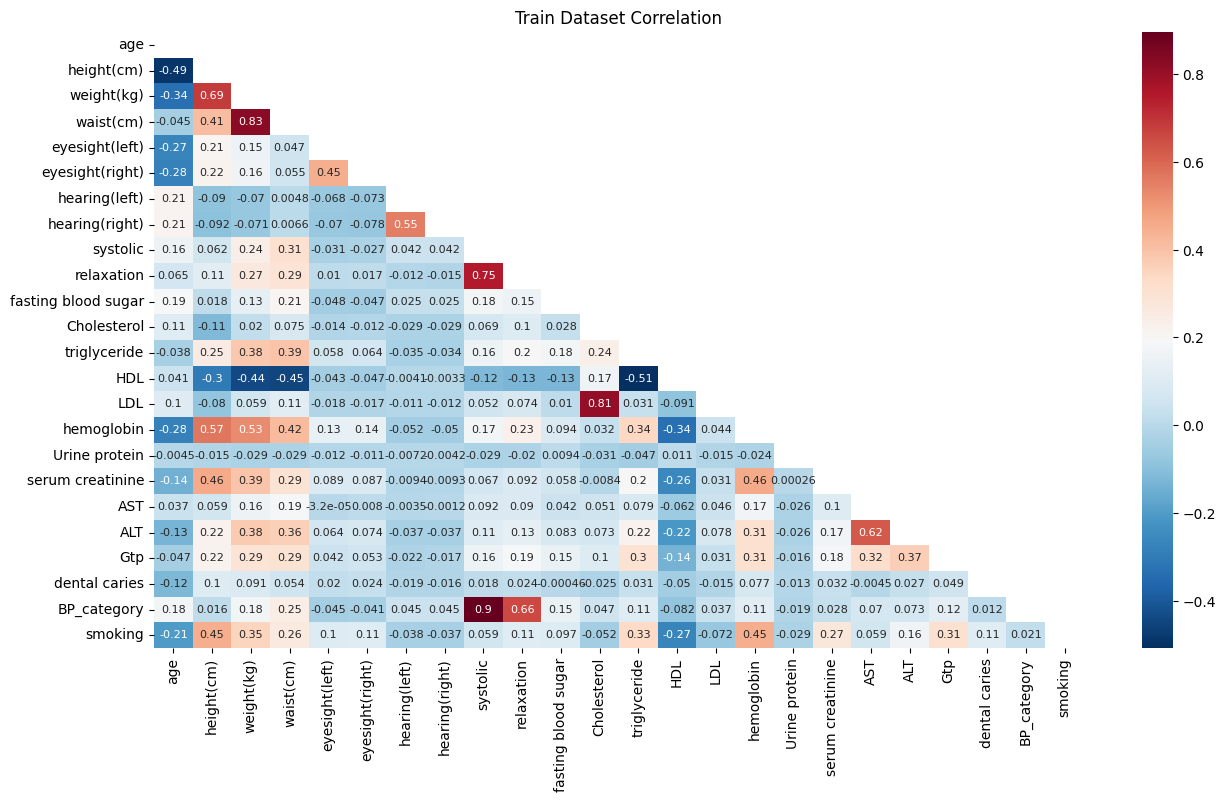

In [18]:
# corr() 메서드를 사용하여 특성 간의 상관 관계 행렬을 계산
trainCorr = df_train.corr()
mask = np.zeros_like(trainCorr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,8))
sns.heatmap(trainCorr, mask=mask, cmap='RdBu_r', annot=True, annot_kws={"size": 8}) # annot=True 매개변수를 사용하여 각 셀에 상관 관계 값을 표시
plt.title('Train Dataset Correlation')
plt.show()

In [19]:
# # target과 각 특성 간의 상관 관계를 계산
# # 특정 상관 관계 threshold를 넘는 특성들을 선택하여 내림차순 정렬
# threshold = 0.05
# corr=abs(trainCorr['smoking'])
# result = corr[corr>threshold]
# result.sort_values(ascending=False)

In [20]:
# # trainData에서 특성 간의 상관 관계를 계산하고, 상관 관계가 높은 특성들을 식별
# columns = df_train.columns.tolist()
# highCorrFeature = []
# for i in range(len(columns)-1, 0, -1):
#     if columns[i] in highCorrFeature:
#         continue
#     for j in range(0,i):
#         if columns[j] in highCorrFeature:
#             continue
#         # 같은 열과의 상관 관계를 계산하는 것을 피하기 위해 다른 열인지 확인
#         if i != j:
#             # columns[i],columns[j]의 상관 관계 계산
#             c = df_train[[columns[i],columns[j]]].corr()
#             # 상관 관계 행렬 c에서 columns[j] 열과 columns[i] 행에 해당하는 값 추출
#             val = c[columns[j]][0] # 이 값은 두 열 간의 상관 관계
#             if val > 0.5:
#                 print(f"{columns[i]} and {columns[j]} has high correlation {val}")
#                 highCorrFeature.append(columns[j])
                
# print(f"\nSize of original data: {df_train.shape[1]-1}, \nnumber of high correlation features: {len(highCorrFeature)}")

In [21]:
# # 높은 상관 관계를 가진 특성들을 제거한 데이터를 x에 저장
# x = df_train.drop(columns=highCorrFeature)
# x = x.drop(columns='smoking')

# # 높은 상관 관계를 가진 특성들을 제외한 특성들의 목록
# featurePC = x.columns.tolist()
# print(f"Selected features: {len(featurePC)} / {featurePC}")

# # 이전에 정의한 generateXY 함수를 사용하여 특성 행렬 x와 타겟 벡터 y를 생성
# x,y = generateXY(df_train)

# # cv 계산
# cv_feature(x,y,featurePC,'Pearson Correlation')

In [22]:
# featurePC = ['age', 'height(cm)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'systolic', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'Urine protein', 'serum creatinine', 'AST', 'Gtp', 'dental caries']

__❌B) Variance Inflation Factor (VIF):__ 다중 공선성 평가
- 다중공선성: 회귀분석에서 독립변수들 간에 강한 상관관계가 나타나는 문제
- 이진 분류 문제에서 사용하는 로지스틱 회귀나 결정 트리 기반 모델 등은 변수 간의 상관관계가 높아도 모델의 성능에 크게 영향을 미치지 않는 경우가 많음

In [23]:
# # VIF를 사용하여 다중공선성을 확인
# # VIF가 일정 임계값을 넘는 특성들을 제거하여 모델에 사용할 특성을 선택

# from statsmodels.stats.outliers_influence import variance_inflation_factor
# def cal_vif(x):
#     # 일반적으로 VIF 10 이상인 특성은 다중공선성 가능성이 높다고 판단
#     thresh = 10
#     output = pd.DataFrame()
#     k = x.shape[1]
#     vif = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    
#     # VIF가 임계값을 넘는 특성 제거
#     for i in range(k):
#         a = np.argmax(vif)
#         print(f'Max vif is for variable Index: {a}')
#         if (vif[a]<=thresh):
#             break
#         if (i==1):
#             output = x.drop(x.columns[a],axis=1)
#             vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
#         elif (i>1):
#             output = output.drop(output.columns[a],axis=1)
#             vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
#     return output

# x,y = generateXY(df_train)
# x = cal_vif(x) # VIF 계산하여 다중공선성 높은 특성을 제거한 결과를 x에 저장
# featureVIF = x.columns.tolist()
# print(f"Selected features: {len(featureVIF)} / {featureVIF}")
# cv_feature(x,y,featureVIF,'Variance Inflation Factor')

### ■ Wrapper Method

__A) Step Forward Selection:__ 특성을 하나씩 추가하면서 모델의 성능을 측정하고 최상의 특성 조합을 찾는 방법

In [24]:
# # 특성 선택에 사용되는 Sequential Feature Selector (SFS)를 활용하는 예제
# # 특성 스텝마다 성능을 확인하고 최고의 성능을 나타낸 특성을 뽑기 위해 catboost를 씀
# # 최후에는 선택된 특성들만을 이용하여 RandomForestRegressor로 학습
# from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# x,y = generateXY(df_train)

# clf = CatBoostClassifier(random_state=seed, logging_level = 'Silent')

# # SequentialFeatureSelector 객체 생성
# sfs1 = sfs(clf, k_features=5, forward=True, floating=False, verbose=1, cv=3) # SFS 초기화

# # SFS를 훈련 데이터에 적용
# sfs1 = sfs1.fit(x, y) 

In [25]:
# # SFS를 통해 선택된 특성들을 확인하고, 이를 사용하여 cv 계산
# feat_cols = list(sfs1.k_feature_idx_)
# featureSFS = x.columns[feat_cols].tolist()

# print(f"Selected features: {len(featureSFS)} / {featureSFS}")
# cv_feature(x, y, featureSFS, 'Step Forward Selection')

__B) Backward elimination:__ 가장 덜 중요한 특성을 하나씩 제거하면서 모델의 성능을 측정, 최적의 특성 집합을 찾을 때까지 반복
- 선형 회귀 모델을 기반으로 하기 때문에, 이진 분류 문제에 직접 적용하기는 어려움

__C) Recursive Feature elimination:__ 재귀적 특성 제거 (RFE)는 지정된 특성 수에 도달할 때까지 모델을 학습하고 가장 약한 특성(들)을 제거
-  RFECV는 Recursive Feature Elimination과 Cross-Validated selection을 통해 최적의 특성 수를 선택

In [26]:
# from sklearn.feature_selection import RFECV

# x, y = generateXY(df_train)

# # CatBoostClassifier 객체 생성
# model = CatBoostClassifier(random_state=seed, logging_level = 'Silent')

# # RFECV를 이용한 Backward Elimination
# rfecv = RFECV(estimator=model, step=1, cv=5)  # step=1은 한 번에 하나의 특성을 제거하겠다는 의미이며, cv=5는 5-fold cross-validation을 수행하겠다는 의미입니다.
# rfecv = rfecv.fit(x, y)

# # 선택된 특성 확인
# featureBE = x.columns[rfecv.support_].tolist()

# print(f"Selected features: {len(featureBE)} / {featureBE}")

# # 선택된 특성으로 cv_feature 함수를 통해 교차 검증 수행
# cv_feature(x, y, featureBE, 'Backward Elimination')

### ■ Embedded Method
모델 훈련 과정에서 특성 선택을 수행하는 방법
> 임베디드 방법은 모델의 훈련 과정에서 특성의 중요도를 반복적으로 평가

1) LogisticRegressionCV 모델을 사용한 Lasso 방법
- 선형 관계를 가정하고 있기 때문에, 특성들이 선형적으로 목표 변수와 관련이 있을 때 유용
- Lasso는 특성의 수를 크게 줄일 수 있어 해석이 쉬운 모델을 만들 수 있음
- 하지만, 특성 간 복잡한 상호작용을 잡아내기 어려움

In [27]:
# from sklearn.linear_model import LogisticRegressionCV

# x,y = generateXY(df_train)
# clf = LogisticRegressionCV(cv=5, Cs=200, tol=1e-4, fit_intercept=False, penalty='l1', solver='liblinear')
# clf.fit(x,y)
# print("Best score: ", clf.score(x,y))

# coef = pd.Series(clf.coef_[0], index=x.columns)
# print("Lasso picked " + str(sum(coef != 0))+ " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

# imp_coef = coef.sort_values()
# featureEM = imp_coef[imp_coef>0].index.tolist()

# print(f"Selected features: {len(featureEM)} / {featureEM}")
# cv_feature(x,y,featureEM,'Embedded Method')

2) CatBoostClassifier 모델을 사용한 특성 중요도 방법
- 비선형 관계와 특성 간의 복잡한 상호작용을 잘 잡아냄
- 특성 중요도를 직접적으로 제공하므로, 어떤 특성이 모델의 예측에 중요한 역할을 하는지 파악하는 데 유용

In [28]:
# # CatBoostClassifier 객체 생성
# clf = CatBoostClassifier(random_state=seed, logging_level = 'Silent')

# # 모델 학습
# clf.fit(x, y)

# # 특성 중요도 계산
# feature_importances = clf.feature_importances_
# sorted_idx = feature_importances.argsort()

# # 시각화
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
# plt.yticks(range(len(feature_importances)), x.columns[sorted_idx])
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('Feature Importance Plot')
# plt.show()

In [29]:
# # 특성 중요도를 기반으로 특성 선택
# featureEM = x.columns[feature_importances > 0.9].tolist()

# print(f"Selected features: {len(featureEM)} / {featureEM}")

# # 선택된 특성으로 cv_feature 함수를 통해 교차 검증 수행
# cv_feature(x, y, featureEM, 'Embedded Method')

### ■ Final Feature Selection

In [30]:
# # 다양한 특성 선택 기법을 통해 선택된 특성들을 모아서 특성 중요도 시각화
# allfeature = featurePC + featureSFS + featureBE + featureEM
# feature, count = np.unique(allfeature, return_counts=True) # 각 특성 빈도 카운트
# featureCount = pd.DataFrame(count,index=feature, columns=['Count'])
# featureCount = featureCount.sort_values(by=['Count'])
# featureCount.plot(kind = "barh") # 막대그래프 표현
# plt.rcParams["figure.figsize"] = (20,10) # 크기 조정
# plt.title("Feature importance based on all selection techniques")

In [31]:
# # 특정 임계값을 넘는 특성들로 최종 모델을 학습하여 cv 계산
# selected_features = []

# for i, val in enumerate(feature):
#     if count[i] > 1:
#         selected_features.append(val)
# print(f"Final Selected features: {len(selected_features)} / {selected_features}")
# X,y = generateXY(df_train)
# clf = cv_feature(X,y,selected_features,"Final model")

---

# ⚠️Pre-process

---

# 🎰Model Optimization (with Optuna)

__- 모델 학습하는 함수 정의__

In [32]:
def optimize_params(objective, n_trials=100, seed=42):
    # Pruner 설정
    pruner = MedianPruner(
        n_warmup_steps=10,  # 첫 10회 trial은 pruner가 적용되지 않습니다.
        interval_steps=1,  # pruner가 적용되는 간격을 설정합니다. 
    )

    # Sampler 설정
    sampler = TPESampler(
        seed=seed  # 재현가능성을 보장하기 위한 시드 값 설정
    )

    # Run optimization.
    study = optuna.create_study(
        direction='maximize',
        pruner=pruner,
        sampler=sampler
    )
    study.optimize(objective, n_trials=n_trials)

    # Get best parameters from study
    best_params = study.best_params

    print(f'Best parameters: {best_params}')
    print(f'Best ROC AUC Score: {study.best_value:.5f}')

A) RandomForestClassifier

In [33]:
# def objectiveRF(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 5, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
#         'max_features': trial.suggest_categorical('max_features', ["sqrt", "log2", None]),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 100, 2000),
#         'max_samples': trial.suggest_float('max_samples', 1e-2, 1, log=True),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True]),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'n_jobs': -1
#     }

#     # Initialize and fit the model.
#     model = RandomForestClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=str_kf)
#     # print(f'RandomForestClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveRF, n_trials=100, seed=42)

B) Extra Trees

In [34]:
# def objectiveET(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         'max_depth': trial.suggest_int('max_depth', 2, 30),
#         'min_impurity_decrease': trial.suggest_float('min_impurity_decrease',1e-10, 1e-2, log=True),
#         # 'min_impurity_decrease': trial.suggest_float('min_impurity_decrease',0.0, 1.0),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
#         'max_features': trial.suggest_float ('max_features', 0.1, 1.0),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 100, 3000),
#         'max_samples': trial.suggest_float('max_samples', 1e-5, 1.0, log=True),
#         # 'max_samples': trial.suggest_float('max_samples', 1e-3, 3e-1, log=True),
#         'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
#         # 'min_weight_fraction_leaf': trial.suggest_float ('min_weight_fraction_leaf', 1e-3, 1e-1),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True]),
#         'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
#         'n_jobs': -1,
#     }

#     # Initialize and fit the model.
#     model = ExtraTreesClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=str_kf)
#     # print(f'ExtraTreesClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveET, n_trials=100, seed=42)

C) Hist Gradient Boosting

In [35]:
# def objectiveHGB(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'l2_regularization': trial.suggest_float('l2_regularization', 1e-5, 10.0, log=True),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
#         'max_iter': trial.suggest_int('max_iter', 100, 2000),
#         'max_depth': trial.suggest_int('max_depth', 1, 100),
#         'max_bins': trial.suggest_int('max_bins', 2, 255),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 2000),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 255),
#     }

#     # Initialize and fit the model.
#     model = HistGradientBoostingClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=str_kf)
#     # print(f'HistGradientBoostingClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveHGB, n_trials=100, seed=42)

D) XGBClassifier

In [36]:
# def objectiveXGB(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         # num_boost_round: GBM의 n_estimators와 같은 파라미터
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 1, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'gamma': trial.suggest_float('gamma', 0.0, 5.0),
#         'alpha': trial.suggest_float('alpha', 0.0, 10.0),
#         'lambda': trial.suggest_float('lambda', 0.0, 10.0),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True), # eta [defalut: 0.3, alias: learning_rate] 
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0), 
#         'tree_method': 'hist',
#         'device': 'cuda',
#         'objective': 'binary:logistic'
#     }

#     # Initialize and fit the model.
#     model = XGBClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=str_kf)
#     # print(f'XGBClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveXGB, n_trials=100, seed=42)

E) LightGBM

In [37]:
# def objectiveLGBM(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         "objective": "binary",
#         "metric": "auc",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
#         "subsample": trial.suggest_float("subsample", 0.1, 1.0),
#         "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
#         'n_estimators': trial.suggest_int("n_estimators", 50, 3000),
#         'max_depth': trial.suggest_int('max_depth', -1, 50),
#         'device_type': 'gpu'
#     }

#     # Initialize and fit the model.
#     model = LGBMClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=str_kf)
#     print(f'LGBMClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveLGBM, n_trials=100, seed=42)

F) CatBoostClassifier

In [38]:
# def objectiveCat(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1200),
#         'depth': trial.suggest_int('depth', 5, 15),
#         'learning_rate': trial.suggest_float("learning_rate", 2e-2, 8e-2, log=True),
#         'random_strength': trial.suggest_float('random_strength', 0.7, 1.3, log=True),
#         'bagging_temperature': trial.suggest_float("bagging_temperature", 0.2, 0.6, log=True),
#         'border_count': trial.suggest_int('border_count', 100, 200),
#         'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 1, 6),
#         'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.2, 1.9, log=True),
#     }

#     # Initialize and fit the model.
#     model = CatBoostClassifier(**params, random_state=seed, logging_level = 'Silent')
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=str_kf)
#     # print(f'CatBoostClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveCat, n_trials=100, seed=42)

In [39]:
# def objectiveCat(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1000),
#         'depth': trial.suggest_int('depth', 5, 7),
#         'learning_rate': trial.suggest_float("learning_rate", 2e-2, 8e-2, log=True),
#         'random_strength': trial.suggest_float('random_strength', 0.6, 0.9),
#         'bagging_temperature': trial.suggest_float("bagging_temperature", 0.2, 0.7),
#         'border_count': trial.suggest_int('border_count', 130, 170),
#         'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 4, 6),
#         'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.2, 1.8),
#     }

#     # Initialize and fit the model.
#     model = CatBoostClassifier(**params, random_state=seed, logging_level = 'Silent')
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=str_kf)
#     # print(f'CatBoostClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveCat, n_trials=100, seed=42)

G) Logistic Regression

In [40]:
# import warnings
# warnings.filterwarnings('ignore')

# # max_iter는 Gradient Descent 방식을 반복해서 몇번 수행할 것인가 인데, 
# # 이게 일단 수렴(Convergence)하게 되면 횟수를 늘려도 성능이 거의 달라지지 않음
# def objectiveLR(trial):
#     # Define the hyperparameters for the trial.
#     penalty_solver = trial.suggest_categorical('penalty_solver', [
#         ('l1', 'liblinear'), 
#         ('l1', 'saga'), 
#         ('l2', 'newton-cg'), 
#         ('l2', 'lbfgs'), 
#         ('l2', 'sag'), 
#         ('l2', 'saga'), 
#         ('elasticnet', 'saga'),
#         ('none', 'newton-cg'),
#         ('none', 'lbfgs'),
#         ('none', 'sag'),
#         ('none', 'saga')
#     ])

#     penalty, solver = penalty_solver

#     if penalty == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
#     else:
#         l1_ratio = None

#     params = {
#         'max_iter': trial.suggest_int('max_iter', 100, 1000),
#         'C': trial.suggest_float('C', 1e-5, 10, log=True),
#         'penalty': penalty,
#         'solver': solver,
#         'l1_ratio': l1_ratio,
#         'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#         'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#         'n_jobs': -1
#     }



#     # Initialize and fit the model.
#     model = LogisticRegression(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=str_kf)
# #     print(f'LogisticRegression has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveLR, n_trials=100, seed=42)

---

# 📈Train

In [41]:
# optuna로 뽑은 최적화 파라미터

opt_rf_params = {'n_estimators': 947, 
                 'max_depth': 29, 
                 'min_samples_split': 31, 
                 'min_samples_leaf': 9, 
                 'max_features': None, 
                 'max_leaf_nodes': 1839, 
                 'max_samples': 0.8650030717488943, 
                 'bootstrap': True, 
                 'criterion': 'entropy',
                 'n_jobs': -1
                 }
opt_et_params = {'n_estimators': 709, 
                 'max_depth': 29, 
                 'min_impurity_decrease': 2.37677144655935e-05, 
                 'criterion': 'gini', 
                 'min_samples_split': 16, 
                 'min_samples_leaf': 6, 
                 'max_features': 0.9622645147955742, 
                 'max_leaf_nodes': 1672, 
                 'max_samples': 0.09822322294168621, 
                 'min_weight_fraction_leaf': 0.000656642715024573, 
                 'bootstrap': True, 
                 'class_weight': None,
                 'n_jobs': -1,
                 } # 0.85538
opt_hgb_params = {'l2_regularization': 7.086578943242248, 
                  'learning_rate': 0.016691512438799662, 
                  'max_iter': 1849, 
                  'max_depth': 31, 
                  'max_bins': 247, 
                  'min_samples_leaf': 631, 
                  'max_leaf_nodes': 91
                  } # 0.86993
opt_xgb_params = {'n_estimators': 973, 
                  'max_depth': 10, 
                  'min_child_weight': 3, 
                  'subsample': 0.9504791909105347, 
                  'colsample_bytree': 0.3028813045040783, 
                  'gamma': 0.9272085943572528, 
                  'alpha': 6.058561922964304, 
                  'lambda': 7.442253995706032, 
                  'learning_rate': 0.034608357960129406, 
                  'scale_pos_weight': 5.066377770811329,
                  'tree_method': 'hist',
                  'device': 'cuda',
                  'objective': 'binary:logistic',
                  'n_jobs': -1,
                  } # 0.87260
opt_lgbm_params = {'reg_alpha': 1.7862129552684525e-06, 
                   'reg_lambda': 4.457649510795302e-07, 
                   'num_leaves': 231, 
                   'colsample_bytree': 0.23633545420416763, 
                   'subsample': 0.41304778630564337, 
                   'subsample_freq': 10, 
                   'min_child_samples': 70, 
                   'learning_rate': 0.011773171567527234, 
                   'n_estimators': 2620, 
                   'max_depth': 18,
                   "objective": "binary",
                   "metric": "auc",
                   "verbosity": -1,
                   "boosting_type": "gbdt",
                   'device_type': 'gpu'
                   }
opt_cat_params = {'iterations': 980, 
                  'depth': 7, 
                  'learning_rate': 0.07645498037017964, 
                  'random_strength': 0.6910564067238075, 
                  'bagging_temperature': 0.371867116122552, 
                  'border_count': 155, 
                  'l2_leaf_reg': 5, 
                  'scale_pos_weight': 1.5475544409461044,
                  'logging_level': 'Silent'
                  }

# optuna에서 계속 같은 점수로 수렴됨. 한계가 있는듯
opt_lr_params = {'penalty':'none', 
                 'solver': 'newton-cg', 
                 'max_iter': 804, 
                 'C': 0.008675998270633417, 
                 'fit_intercept': True, 
                 'class_weight': None
                 } # 0.834328887524651

In [42]:
# Define the original models.
# Logistic Regression Reference: https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense
origin_models = {
    "Random Forest": RandomForestClassifier(random_state=seed, **opt_rf_params),
    "Extra Trees": ExtraTreesClassifier(random_state=seed, **opt_et_params),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=seed, **opt_hgb_params),
    "XGBoost": XGBClassifier(random_state=seed, **opt_xgb_params),
    "LightGBM": LGBMClassifier(random_state=seed, **opt_lgbm_params),
    "CatBoost": CatBoostClassifier(random_state=seed, **opt_cat_params),
    # "LogisticRegression": LogisticRegression(random_state=seed, max_iter=2000, n_jobs=-1),
}

In [43]:
# Define the pipelines
log_transformer = FunctionTransformer(np.log1p)
pipelines = {
    "Random Forest": make_pipeline(RobustScaler(),
                                   RandomForestClassifier(random_state=seed, n_jobs=-1)),
    "Extra Trees": make_pipeline(log_transformer,
                                 ExtraTreesClassifier(random_state=seed, n_jobs=-1)),
    "Hist Gradient Boosting": make_pipeline(HistGradientBoostingClassifier(random_state=seed)),
    "XGBoost": make_pipeline(QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=seed),
                             XGBClassifier(random_state=seed, n_jobs=-1)),
    "LightGBM": make_pipeline(LGBMClassifier(random_state=seed, verbosity=-1)),
    "CatBoost": make_pipeline(RobustScaler(),
                              CatBoostClassifier(random_state=seed, logging_level = 'Silent')),
    # "LogisticRegression": LogisticRegression(random_state=seed, max_iter=2000, n_jobs=-1),
}

### __1) VotingClassifier 앙상블__ (with Weights)
- RidgeClassifier로 모델별 가중치 추출

### 모델별로 어떤 스케일이 좋은지 판단

In [44]:
def cv_oof_preds(models, X, y, cv):
    """
    Perform cross-validation for each model and generate out-of-fold predictions.

    Args:
    - models: a dictionary of Scikit-learn models
    - X: features
    - y: target variable
    - cv: cross-validation splitter

    Returns:
    - a DataFrame of out-of-fold predictions
    - a list of average ROC AUC scores for each model
    """
    # Create a DataFrame to store out-of-fold predictions.
    oof_predictions = pd.DataFrame(index=y.index)

    # Create an empty list to store the average ROC AUC scores
    avg_roc_auc_scores = []

    # Iterate over each model and compute cross-validated predictions.
    for name, model in models.items():
        # Create an empty array to store the out-of-fold predictions
        oof_preds = np.zeros(y.shape[0])

        # Create an empty list to store the ROC AUC scores
        roc_auc_scores = []

        # Perform cross-validation
        for train_index, valid_index in cv.split(X, y):
            # Clone the model to ensure that it's reset for each fold
            model_clone = clone(model)

            # Split the data
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # Fit the model
            model_clone.fit(X_train, y_train)

            # Compute predictions
            preds = model_clone.predict_proba(X_valid)[:, 1]

            # Store predictions for this fold in oof_preds
            oof_preds[valid_index] = preds

            # Compute the ROC AUC score and append it to the list
            score = roc_auc_score(y_valid, preds)
            roc_auc_scores.append(score)

        # Store the predictions in the DataFrame
        oof_predictions[name] = oof_preds

        # Store the average ROC AUC score and print
        avg_roc_auc_score = np.mean(roc_auc_scores)
        avg_roc_auc_scores.append(avg_roc_auc_score)
        
        print(f"{name} ROC AUC Score(Avg): {avg_roc_auc_score:.7f}")
    print(f"★Models ROC AUC Score(Avg) = {np.mean(avg_roc_auc_scores):.7f} ± {np.std(avg_roc_auc_scores) * 2:.5f}\n")

    return oof_predictions

In [45]:
# ############ 학습 두 번해서 비효율적이지만 확실한 코드 #############
# def cv_oof_preds(models, X, y, cv):
#     # Create a DataFrame to store out-of-fold predictions.
#     oof_predictions = pd.DataFrame()

#     # Create an empty list to store the average ROC AUC scores
#     avg_roc_auc_scores = []

#     # Iterate over each model and compute cross-validated predictions.
#     for name, model in models.items():
#         # Compute cross-validated predictions.
#         oof_preds = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

#         # Store the predictions in the DataFrame.
#         oof_predictions[name] = oof_preds

#         # Store the ROC AUC Score & print
#         score = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=cv))
#         print(f"{name} ROC AUC Score(Avg) {score:.7f}")
#         avg_roc_auc_scores.append(score)

#     return oof_predictions, avg_roc_auc_scores

In [46]:
def apply_scaling_and_cv(models, X, y, cv):
    """
    Apply different scaling methods, log transformation, and no scaling to the data and perform cross-validation for each model.
    """
    # Define the scaling methods
    scalers = {
        'NoScaling': None,  # Add no scaling
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'QuantileTransformer': QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=seed),
        'LogTransform': None  # Add log transformation
    }

    # Create dictionaries to store the results
    all_oof_predictions = {}
    all_avg_roc_auc_scores = {}

    # Apply each scaling method
    for scaler_name, scaler in scalers.items():
        print(f"[Applying {scaler_name}...]")

        if scaler_name == 'NoScaling':
            # Do not scale the features
            X_scaled = X.copy()
        elif scaler_name == 'LogTransform':
            # Apply log transformation
            X_scaled = np.log1p(X)
        else:
            # Scale the features
            X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        # Perform cross-validation and generate out-of-fold predictions
        oof_predictions, avg_roc_auc_scores = cv_oof_preds(models, X_scaled, y, cv)

        # Store the results
        all_oof_predictions[scaler_name] = oof_predictions
        all_avg_roc_auc_scores[scaler_name] = avg_roc_auc_scores

    # Print the best scaling method for each model
    print(f"[⚠️The best scaling]")
    for model_name in models.keys():
        best_method, best_score = max(
            ((method, scores[i]) for method, scores in all_avg_roc_auc_scores.items() for i, model in enumerate(models) if model == model_name),
            key=lambda x: x[1]
        )
        print(f"For {model_name}, the best scaling method is {best_method} / {best_score:.7f}")

    return all_oof_predictions, all_avg_roc_auc_scores


In [47]:
def perform_voting(models, X, y, cv):
    oof_predictions = cv_oof_preds(models, X, y, cv)

    # Fit a Ridge Classifier to compute the weights.
    weights = RidgeClassifier(random_state=seed).fit(oof_predictions, y).coef_[0]
    print(pd.DataFrame(weights, index = list(oof_predictions), columns = ['weight per model']))

    # Create a voting classifier.
    voting_clf = VotingClassifier(estimators=list(models.items()), voting='soft', weights=weights.tolist())

    # compute cross-validated
    voting_score = cross_val_score(voting_clf, X, y, scoring='roc_auc', cv=cv)
    print(f"VotingClassifier ROC AUC Score(Avg) {np.mean(voting_score):.7f} ± {np.std(voting_score) * 2:.5f}")

    # Fit the model to the training data.
    voting_clf.fit(X, y)

    return voting_clf

In [48]:
############ 로그 변환 포함 어떤 스케일링이 제일 효과적인지 계산 #############
# Apply the function to compute out-of-fold predictions and average ROC AUC scores
X, y = generateXY(df_train)
str_kf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=seed)

all_oof_predictions, all_avg_roc_auc_scores = apply_scaling_and_cv(origin_models, X, y, str_kf) # Modify Models

# For each scaling method, create a VotingClassifier based on the out-of-fold predictions
for scaler_name in all_oof_predictions.keys():
    print(f"\nApplying VotingClassifier for {scaler_name}...")

    # Get the out-of-fold predictions for the current scaling method
    oof_predictions = all_oof_predictions[scaler_name]

    # Fit a Ridge Classifier to compute the weights.
    weights = RidgeClassifier(random_state=seed).fit(oof_predictions, y).coef_[0]
    print(pd.DataFrame(weights, index = list(oof_predictions), columns = ['weight per model']))

    # Create a voting classifier.
    voting_clf = VotingClassifier(estimators=list(origin_models.items()), voting='soft', weights=weights.tolist()) # Modify Models

    # Compute cross-validated
    voting_score = cross_val_score(voting_clf, X, y, scoring='roc_auc', cv=str_kf)
    print(f"★VotingClassifier ROC AUC Score(Avg) {np.mean(voting_score):.7f} ± {np.std(voting_score) * 2:.5f}")

    # Fit the model to the training data.
    voting_clf.fit(X, y)


[Applying NoScaling...]


KeyboardInterrupt: 

In [49]:
# '''
# Voting 앙상블 예측값 추출
# '''
# X, y = generateXY(df_train)
# voting_clf = perform_voting(origin_models, X, y, str_kf)

In [50]:
# # Orignal data
# Random Forest ROC AUC Score(Avg) 0.8567929
# Extra Trees ROC AUC Score(Avg) 0.8528634
# Hist Gradient Boosting ROC AUC Score(Avg) 0.8647233
# XGBoost ROC AUC Score(Avg) 0.8651536
# LightGBM ROC AUC Score(Avg) 0.8650397
# CatBoost ROC AUC Score(Avg) 0.8687767
# ★Models ROC AUC Score(Avg) = 0.8622249 +/- 0.01104

# # 피쳐 추가 4개
# Random Forest ROC AUC Score(Avg) 0.8563007
# Extra Trees ROC AUC Score(Avg) 0.8514791
# Hist Gradient Boosting ROC AUC Score(Avg) 0.8642605
# XGBoost ROC AUC Score(Avg) 0.8646463
# LightGBM ROC AUC Score(Avg) 0.8646350
# CatBoost ROC AUC Score(Avg) 0.8684472
# ★Models ROC AUC Score(Avg) = 0.8616281 +/- 0.01163

# # BP_cat
# Random Forest ROC AUC Score(Avg) 0.8568423
# Extra Trees ROC AUC Score(Avg) 0.8516239
# Hist Gradient Boosting ROC AUC Score(Avg) 0.8647233
# XGBoost ROC AUC Score(Avg) 0.8651536
# LightGBM ROC AUC Score(Avg) 0.8650397
# CatBoost ROC AUC Score(Avg) 0.8688645
# ★Models ROC AUC Score(Avg) = 0.8620412 ± 0.01178

CV 점수 모음

In [51]:
# Original
# VotingClassifier ROC AUC Score(Avg) 0.8693841

# 시력2+청력2+클리핑
# VotingClassifier ROC AUC Score(Avg) 0.8692936 ± 0.00230

# 퍼스널 스케일링
# VotingClassifier ROC AUC Score(Avg) 0.8693923 ± 0.00196

# NumtoCat
# VotingClassifier ROC AUC Score(Avg) 0.8691293 ± 0.00255

### __2) Hill_Climbing 앙상블__ (with Weights)

In [52]:
def hill_climbing(x, y, x_test):

    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True

    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds

    return [hill_ens_pred_1, hill_ens_pred_2]

In [53]:
def perform_hill_climbing(models, X, y, cv):
    hill_ens_cv_scores, hill_ens_preds = list(), list()

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[test_idx]

        preds_train = {}
        preds_test = {}
        for name, model in models.items():
            trained_model = model.fit(X_train_fold, y_train_fold)
            preds_train[name] = trained_model.predict_proba(X_val_fold)[:, 1]
            preds_test[name] = trained_model.predict_proba(df_test)[:, 1]

        oof_df_train, oof_df_test = pd.DataFrame(preds_train), pd.DataFrame(preds_test)

        hill_results = hill_climbing(oof_df_train, y_val_fold, oof_df_test)

        hill_ens_score_fold = roc_auc_score(y_val_fold, hill_results[0])
        hill_ens_cv_scores.append(hill_ens_score_fold)
        hill_ens_preds.append(hill_results[1])

        print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

    print(f"★The hill climbing ensemble oof ROC-AUC score over the {n_splits}-folds is {np.mean(hill_ens_cv_scores):.7f} ± {np.std(hill_ens_cv_scores) * 2:.5f}")
    return hill_ens_preds


- 힐클라이밍 앙상블 수행

In [54]:
X, y = generateXY(df_train)

hill_ens_preds = perform_hill_climbing(origin_models, X, y, str_kf)


c:\Users\Gyeom\anaconda3\envs\torch_3.11\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fold 0 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.871158621852057
Fold 1 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8742767645656455
Fold 2 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8786360761197245
Fold 3 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8737740225991661
Fold 4 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8749194503452905
Fold 5 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.873416871530641
Fold 6 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8718786053994463
Fold 7 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.874931849938468
Fold 8 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8747375749923085
Fold 9 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8739549789765153
★The hill climbing ensemble oof ROC-AUC score over the 5-folds is 0.8741685 ± 0.00382


In [55]:
# 힐클라이밍
# The hill climbing ensemble oof ROC-AUC score over the 5-folds is 0.8694200484110238

# 힐클라이밍+퍼스널 스케일링 0.87254
# The hill climbing ensemble oof ROC-AUC score over the 5-folds is 0.8694473851140737

# 힐클라이밍 + 혈압 관련 피처 추가
# ★The hill climbing ensemble oof ROC-AUC score over the 5-folds is 0.8694840 ± 0.00207

# 힐클라이밍 + NumtoCat
# ★The hill climbing ensemble oof ROC-AUC score over the 5-folds is 0.8691562 ± 0.00244

---

# 📝Final Submit

In [56]:
# # VotingClassifier 앙상블 예측값 추출
# # Make predictions on test data. 
# test_predictions = voting_clf.predict_proba(df_test)[:, 1]

In [57]:
# Hill_Climbing 앙상블 예측값 추출
test_predictions = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)

In [58]:
df_submit = pd.DataFrame({'id':ids_test,'smoking': test_predictions})
df_submit.head()

,id,smoking
0,159256,0.746131
1,159257,0.341887
2,159258,0.529275
3,159259,0.030834
4,159260,0.727169


In [60]:
# df_submit.to_csv('submission19.csv', index=False)
# !kaggle competitions submit -c playground-series-s3e24 -f submission19.csv -m "힐클라이밍+fold10+혈압+최적화"

Successfully submitted to Binary Prediction of Smoker Status using Bio-Signals



  0%|          | 0.00/2.77M [00:00<?, ?B/s]
  0%|          | 8.00k/2.77M [00:00<01:06, 43.7kB/s]
  7%|▋         | 208k/2.77M [00:00<00:02, 907kB/s]  
 21%|██        | 592k/2.77M [00:00<00:01, 1.95MB/s]
 33%|███▎      | 928k/2.77M [00:00<00:00, 2.17MB/s]
 41%|████      | 1.13M/2.77M [00:00<00:00, 1.74MB/s]
 48%|████▊     | 1.32M/2.77M [00:00<00:00, 1.70MB/s]
 54%|█████▍    | 1.50M/2.77M [00:00<00:00, 1.67MB/s]
 61%|██████    | 1.70M/2.77M [00:01<00:00, 1.76MB/s]
 68%|██████▊   | 1.88M/2.77M [00:01<00:00, 1.75MB/s]
 75%|███████▍  | 2.07M/2.77M [00:01<00:00, 1.82MB/s]
 83%|████████▎ | 2.29M/2.77M [00:01<00:00, 1.91MB/s]
 90%|█████████ | 2.51M/2.77M [00:01<00:00, 2.00MB/s]
 99%|█████████▉| 2.76M/2.77M [00:01<00:00, 2.17MB/s]
100%|██████████| 2.77M/2.77M [00:03<00:00, 756kB/s] 
